In [1]:
import torch
import numpy as np
from pandas import factorize, DataFrame
from copy import deepcopy
from matplotlib import pyplot as plt

from uncertain.models.ExplicitFactorizationModel import ExplicitFactorizationModel
from uncertain.models.UncertainWrapper import UncertainWrapper, LinearUncertaintyEstimator
from uncertain.models.multimodelling import EnsembleRecommender, ResampleRecommender
from uncertain.cross_validation import user_based_split, random_train_test_split
from uncertain.interactions import Interactions
from uncertain.models.CPMF import CPMF
from uncertain.models.OrdRec import OrdRec
from uncertain.datasets.goodbooks import get_goodbooks_dataset

from utils import evaluate

train = get_goodbooks_dataset()
train, test = random_train_test_split(train, test_percentage=0.2, random_state=0)
train.gpu()
test.gpu()

MF_params = {'embedding_dim': 10, 'n_iter': 50, 'l2_penalty': 1e-5,
             'learning_rate': 0.001, 'batch_size': 2048, 'use_cuda': True}
CPMF_params = {'embedding_dim': 10, 'n_iter': 50, 'l2_base': 1e-5, 'l2_var': 5e-5,
               'learning_rate': 0.001, 'batch_size': 2048, 'use_cuda': True}
OrdRec_params = {'embedding_dim': 10, 'n_iter': 50, 'l2_base': 5e-7, 'l2_step': 3e-7,
                 'learning_rate': 0.001, 'batch_size': 2048, 'use_cuda': True}

models = {}

In [2]:
models['Baseline'] = ExplicitFactorizationModel(**MF_params)
models['Baseline'].fit(train)
models['Baseline'].evaluation = evaluate(models['Baseline'], test, train, uncertainty=False)
models['Baseline'].evaluation

FunkSVD: 100%|██████████| 50/50 [02:20<00:00,  2.80s/it, Epoch 50 loss: 0.6465447913655887]


{'RMSE': tensor(0.8448, device='cuda:0'),
 'Precision': tensor([0.0943, 0.0842, 0.0756, 0.0697, 0.0650, 0.0613, 0.0585, 0.0561, 0.0542,
         0.0524], device='cuda:0'),
 'Recall': tensor([0.0069, 0.0123, 0.0165, 0.0201, 0.0232, 0.0262, 0.0290, 0.0317, 0.0343,
         0.0368], device='cuda:0')}

In [3]:
models['User support'] = UncertainWrapper(models['Baseline'], LinearUncertaintyEstimator(-train.get_user_support(), None))
models['User support'].evaluation = evaluate(models['User support'], test, train, uncertainty=True)
models['User support'].evaluation

{'RMSE': tensor(0.8448, device='cuda:0'),
 'Precision': tensor([0.0943, 0.0842, 0.0756, 0.0697, 0.0650, 0.0613, 0.0585, 0.0561, 0.0542,
         0.0524], device='cuda:0'),
 'Recall': tensor([0.0069, 0.0123, 0.0165, 0.0201, 0.0232, 0.0262, 0.0290, 0.0317, 0.0343,
         0.0368], device='cuda:0'),
 'Quantile RMSE': tensor([0.8441, 0.8286, 0.8290, 0.8288, 0.8393, 0.8367, 0.8409, 0.8390, 0.8488,
         0.8419, 0.8373, 0.8410, 0.8401, 0.8391, 0.8606, 0.8455, 0.8529, 0.8437,
         0.8571, 0.8987]),
 'Quantile MAP': tensor([0.0676, 0.0640, 0.0662, 0.0607, 0.0607, 0.0604, 0.0572, 0.0533, 0.0573,
         0.0542, 0.0495, 0.0501, 0.0496, 0.0492, 0.0498, 0.0451, 0.0471, 0.0415,
         0.0370, 0.0317]),
 'RRI': tensor([nan, nan, nan, nan, nan, -inf, nan, nan, nan]),
 'Correlation': (tensor(0.0216, device='cuda:0'),
  tensor(0.0188, device='cuda:0')),
 'RPI': tensor(0.0608, device='cuda:0'),
 'Classification': (-0.5328830568946101, 0.5112383077994243)}

In [4]:
models['Item support'] = UncertainWrapper(models['Baseline'], LinearUncertaintyEstimator(None, -train.get_item_support()))
models['Item support'].evaluation = evaluate(models['Item support'], test, train, uncertainty=True)
models['Item support'].evaluation

{'RMSE': tensor(0.8448, device='cuda:0'),
 'Precision': tensor([0.0943, 0.0842, 0.0756, 0.0697, 0.0650, 0.0613, 0.0585, 0.0561, 0.0542,
         0.0524], device='cuda:0'),
 'Recall': tensor([0.0069, 0.0123, 0.0165, 0.0201, 0.0232, 0.0262, 0.0290, 0.0317, 0.0343,
         0.0368], device='cuda:0'),
 'Quantile RMSE': tensor([0.7862, 0.8692, 0.8687, 0.8537, 0.8527, 0.8385, 0.8351, 0.8382, 0.8122,
         0.8297, 0.8127, 0.8146, 0.8146, 0.8145, 0.8225, 0.8249, 0.8341, 0.8523,
         0.8998, 0.9984]),
 'Quantile MAP': tensor([0.0410, 0.0549, 0.0662, 0.0827, 0.0844, 0.0827, 0.0826, 0.0764, 0.0712,
         0.0672, 0.0665, 0.0555, 0.0501, 0.0442, 0.0364, 0.0324, 0.0247, 0.0157,
         0.0083, 0.0047]),
 'RRI': tensor([0.2557, 0.4250, 0.5308, 0.6079, 0.6653, 0.6979, 0.7253, 0.7511, 0.7701]),
 'Correlation': (tensor(0.0361, device='cuda:0'),
  tensor(0.0665, device='cuda:0')),
 'RPI': tensor(0.0024, device='cuda:0'),
 'Classification': (-0.5325175553016928, 0.5340830049355219)}

In [5]:
models['Item variance'] = UncertainWrapper(models['Baseline'], LinearUncertaintyEstimator(None, train.get_item_variance()))
models['Item variance'].evaluation = evaluate(models['Item variance'], test, train, uncertainty=True)
models['Item variance'].evaluation

{'RMSE': tensor(0.8448, device='cuda:0'),
 'Precision': tensor([0.0943, 0.0842, 0.0756, 0.0697, 0.0650, 0.0613, 0.0585, 0.0561, 0.0542,
         0.0524], device='cuda:0'),
 'Recall': tensor([0.0069, 0.0123, 0.0165, 0.0201, 0.0232, 0.0262, 0.0290, 0.0317, 0.0343,
         0.0368], device='cuda:0'),
 'Quantile RMSE': tensor([0.6868, 0.7412, 0.7566, 0.7747, 0.7705, 0.7966, 0.7992, 0.8157, 0.8082,
         0.8224, 0.8446, 0.8451, 0.8699, 0.8671, 0.8831, 0.9043, 0.9164, 0.9348,
         0.9585, 1.0245]),
 'Quantile MAP': tensor([0.0064, 0.0122, 0.0174, 0.0277, 0.0368, 0.0408, 0.0445, 0.0492, 0.0470,
         0.0518, 0.0563, 0.0634, 0.0674, 0.0754, 0.0717, 0.0785, 0.0720, 0.0772,
         0.0817, 0.0708]),
 'RRI': tensor([-0.0644, -0.1314, -0.1754, -0.2116, -0.2431, -0.2609, -0.2775, -0.2952,
         -0.3083]),
 'Correlation': (tensor(0.1197, device='cuda:0'),
  tensor(0.1083, device='cuda:0')),
 'RPI': tensor(0.4514, device='cuda:0'),
 'Classification': (-0.5282878153818635, 0.570672186096

In [6]:
models['Ensemble'] = EnsembleRecommender(base_model=models['Baseline'], n_models=10)
models['Ensemble'].fit(train)
models['Ensemble'].evaluation = evaluate(models['Ensemble'], test, train, uncertainty=True)
models['Ensemble'].evaluation

Ensemble: 100%|██████████| 9/9 [21:12<00:00, 141.44s/it]


{'RMSE': tensor(0.8373, device='cuda:0'),
 'Precision': tensor([0.1022, 0.0902, 0.0807, 0.0742, 0.0689, 0.0649, 0.0616, 0.0587, 0.0565,
         0.0545], device='cuda:0'),
 'Recall': tensor([0.0078, 0.0135, 0.0178, 0.0216, 0.0250, 0.0280, 0.0309, 0.0335, 0.0362,
         0.0387], device='cuda:0'),
 'Quantile RMSE': tensor([0.7798, 0.8059, 0.8152, 0.8246, 0.8302, 0.8307, 0.8322, 0.8370, 0.8305,
         0.8327, 0.8273, 0.8256, 0.8191, 0.8184, 0.8133, 0.8231, 0.8313, 0.8556,
         0.8889, 1.0023]),
 'Quantile MAP': tensor([0.0098, 0.0158, 0.0204, 0.0259, 0.0335, 0.0361, 0.0456, 0.0513, 0.0546,
         0.0626, 0.0637, 0.0715, 0.0749, 0.0765, 0.0795, 0.0794, 0.0823, 0.0768,
         0.0699, 0.0593]),
 'RRI': tensor([-0.1091, -0.1591, -0.1720, -0.1810, -0.1905, -0.1977, -0.2078, -0.2133,
         -0.2204]),
 'Correlation': (tensor(0.0587, device='cuda:0'),
  tensor(0.0120, device='cuda:0')),
 'RPI': tensor(0.3125, device='cuda:0'),
 'Classification': (-0.5275120244617724, 0.511714853443

In [7]:
models['Resample'] = ResampleRecommender(base_model=models['Baseline'], n_models=10)
models['Resample'].fit(train)
models['Resample'].evaluation = evaluate(models['Resample'], test, train, uncertainty=True)
models['Resample'].evaluation

Resample: 100%|██████████| 10/10 [21:17<00:00, 127.76s/it]


{'RMSE': tensor(0.8448, device='cuda:0'),
 'Precision': tensor([0.0943, 0.0842, 0.0756, 0.0697, 0.0650, 0.0613, 0.0585, 0.0561, 0.0542,
         0.0524], device='cuda:0'),
 'Recall': tensor([0.0069, 0.0123, 0.0165, 0.0201, 0.0232, 0.0262, 0.0290, 0.0317, 0.0343,
         0.0368], device='cuda:0'),
 'Quantile RMSE': tensor([0.7968, 0.7993, 0.8095, 0.8099, 0.8132, 0.8181, 0.8148, 0.8152, 0.8227,
         0.8261, 0.8295, 0.8249, 0.8327, 0.8366, 0.8425, 0.8532, 0.8550, 0.8752,
         0.9224, 1.0602]),
 'Quantile MAP': tensor([0.0225, 0.0294, 0.0370, 0.0388, 0.0419, 0.0466, 0.0512, 0.0543, 0.0567,
         0.0616, 0.0590, 0.0623, 0.0652, 0.0606, 0.0652, 0.0672, 0.0618, 0.0620,
         0.0582, 0.0464]),
 'RRI': tensor([ 0.0130,  0.0041,  0.0021,  0.0022, -0.0086, -0.0129, -0.0174, -0.0252,
         -0.0338]),
 'Correlation': (tensor(0.0884, device='cuda:0'),
  tensor(0.0438, device='cuda:0')),
 'RPI': tensor(0.4710, device='cuda:0'),
 'Classification': (-0.5311173595339735, 0.528982943195

In [8]:
fold1, fold2 = random_train_test_split(train, random_state=0, test_percentage=0.5)
model_cv = deepcopy(models['Baseline'])
model_cv._initialize(fold1)
model_cv.fit(fold1)
predictions1 = model_cv.predict(fold2.user_ids, fold2.item_ids)
model_cv._initialize(fold2)
model_cv.fit(fold2)
predictions2 = model_cv.predict(fold1.user_ids, fold1.item_ids)
train_errors = torch.cat((torch.abs(fold2.ratings - predictions1), torch.abs(fold1.ratings - predictions2)))
train_errors = Interactions(torch.cat((fold2.user_ids, fold1.user_ids)),
                            torch.cat((fold2.item_ids, fold1.item_ids)),
                            train_errors, num_users=train.num_users, num_items=train.num_items)

In [9]:
models['FCV'] = ExplicitFactorizationModel(**MF_params)
models['FCV'].fit(train_errors)
models['FCV'] = UncertainWrapper(models['Baseline'], models['FCV'])
models['FCV'].evaluation = evaluate(models['FCV'], test, train, uncertainty=True)
models['FCV'].evaluation

FunkSVD: 100%|██████████| 50/50 [02:21<00:00,  2.84s/it, Epoch 50 loss: 0.2762149578179741] 


{'RMSE': tensor(0.8448, device='cuda:0'),
 'Precision': tensor([0.0943, 0.0842, 0.0756, 0.0697, 0.0650, 0.0613, 0.0585, 0.0561, 0.0542,
         0.0524], device='cuda:0'),
 'Recall': tensor([0.0069, 0.0123, 0.0165, 0.0201, 0.0232, 0.0262, 0.0290, 0.0317, 0.0343,
         0.0368], device='cuda:0'),
 'Quantile RMSE': tensor([0.6170, 0.7003, 0.7182, 0.7327, 0.7480, 0.7596, 0.7673, 0.7844, 0.7894,
         0.8021, 0.8218, 0.8288, 0.8523, 0.8642, 0.8846, 0.9123, 0.9459, 0.9848,
         1.0416, 1.1594]),
 'Quantile MAP': tensor([0.0223, 0.0323, 0.0385, 0.0425, 0.0420, 0.0454, 0.0469, 0.0496, 0.0544,
         0.0561, 0.0570, 0.0615, 0.0573, 0.0603, 0.0657, 0.0645, 0.0646, 0.0656,
         0.0632, 0.0583]),
 'RRI': tensor([ 0.0265,  0.0102, -0.0131, -0.0341, -0.0514, -0.0643, -0.0764, -0.0939,
         -0.1093]),
 'Correlation': (tensor(0.2066, device='cuda:0'),
  tensor(0.1840, device='cuda:0')),
 'RPI': tensor(0.7202, device='cuda:0'),
 'Classification': (-0.5198504579230084, 0.610498611056

In [10]:
MF_params['embedding_dim'] = 0
models['BCV'] = ExplicitFactorizationModel(**MF_params)
models['BCV'].fit(train_errors)
models['BCV'] = UncertainWrapper(models['Baseline'], models['BCV'])
models['BCV'].evaluation = evaluate(models['BCV'], test, train, uncertainty=True)
models['BCV'].evaluation

Linear recommender: 100%|██████████| 50/50 [02:22<00:00,  2.85s/it, Epoch 50 loss: 0.26273450575114826]


{'RMSE': tensor(0.8448, device='cuda:0'),
 'Precision': tensor([0.0943, 0.0842, 0.0756, 0.0697, 0.0650, 0.0613, 0.0585, 0.0561, 0.0542,
         0.0524], device='cuda:0'),
 'Recall': tensor([0.0069, 0.0123, 0.0165, 0.0201, 0.0232, 0.0262, 0.0290, 0.0317, 0.0343,
         0.0368], device='cuda:0'),
 'Quantile RMSE': tensor([0.4687, 0.5879, 0.6400, 0.6724, 0.6967, 0.7262, 0.7486, 0.7667, 0.7902,
         0.8111, 0.8270, 0.8492, 0.8729, 0.8910, 0.9152, 0.9460, 0.9832, 1.0256,
         1.0891, 1.2273]),
 'Quantile MAP': tensor([0.0181, 0.0307, 0.0361, 0.0379, 0.0432, 0.0459, 0.0475, 0.0516, 0.0508,
         0.0538, 0.0579, 0.0595, 0.0603, 0.0653, 0.0655, 0.0655, 0.0685, 0.0673,
         0.0638, 0.0589]),
 'RRI': tensor([ 0.0276, -0.0079, -0.0374, -0.0593, -0.0800, -0.0935, -0.1092, -0.1279,
         -0.1389]),
 'Correlation': (tensor(0.2927, device='cuda:0'),
  tensor(0.2622, device='cuda:0')),
 'RPI': tensor(0.9380, device='cuda:0'),
 'Classification': (-0.5028032496246777, 0.665844051450

In [34]:
CPMF_params = {'embedding_dim': 10, 'n_iter': 50, 'l2_base': 1.5e-5, 'l2_var': 5e-6,
               'learning_rate': 0.001, 'batch_size': 2048, 'use_cuda': True}
train = get_goodbooks_dataset()
train, test = random_train_test_split(train, test_percentage=0.2, random_state=0)
train.gpu()
test.gpu()

In [35]:
models['CPMF'] = CPMF(**CPMF_params)
models['CPMF'].fit(train)
models['CPMF'].evaluation = evaluate(models['CPMF'], test, train, uncertainty=True)
models['CPMF'].evaluation

CPMF: 100%|██████████| 50/50 [04:06<00:00,  4.93s/it, Epoch 50 loss: 0.3995661762082347] 


{'RMSE': tensor(0.8526, device='cuda:0'),
 'Precision': tensor([0.0930, 0.0827, 0.0758, 0.0700, 0.0655, 0.0617, 0.0584, 0.0557, 0.0535,
         0.0514], device='cuda:0'),
 'Recall': tensor([0.0067, 0.0120, 0.0163, 0.0200, 0.0234, 0.0263, 0.0290, 0.0316, 0.0340,
         0.0363], device='cuda:0'),
 'Quantile RMSE': tensor([0.5805, 0.5385, 0.6076, 0.6544, 0.6824, 0.7057, 0.7300, 0.7585, 0.7800,
         0.8046, 0.8238, 0.8459, 0.8714, 0.8981, 0.9286, 0.9594, 0.9978, 1.0454,
         1.1236, 1.3017]),
 'Quantile MAP': tensor([0.0261, 0.0376, 0.0430, 0.0464, 0.0466, 0.0471, 0.0505, 0.0527, 0.0538,
         0.0533, 0.0564, 0.0552, 0.0572, 0.0567, 0.0575, 0.0558, 0.0575, 0.0572,
         0.0585, 0.0590]),
 'RRI': tensor([0.0915, 0.1461, 0.1825, 0.2042, 0.2183, 0.2303, 0.2366, 0.2409, 0.2436]),
 'Correlation': (tensor(0.3311, device='cuda:0'),
  tensor(0.3130, device='cuda:0')),
 'RPI': tensor(1.0232, device='cuda:0'),
 'Classification': (-0.5002591000597625, 0.6863675429207083)}

In [12]:
factor = factorize(train.ratings.cpu(), sort=True)
rating_labels = torch.from_numpy(factor[1].astype(np.float64)).cuda()
train.ratings = torch.from_numpy(factor[0]).cuda()

models['OrdRec'] = OrdRec(rating_labels, **OrdRec_params)
models['OrdRec'].fit(train)
models['OrdRec'].evaluation = evaluate(models['OrdRec'], test, train, uncertainty=True)
models['OrdRec'].evaluation

OrdRec: 100%|██████████| 50/50 [05:25<00:00,  6.52s/it, Epoch 50 loss: -0.5209806348195168] 


{'RMSE': tensor(0.9284, device='cuda:0', dtype=torch.float64),
 'Precision': tensor([0.0994, 0.0851, 0.0747, 0.0672, 0.0622, 0.0583, 0.0552, 0.0529, 0.0505,
         0.0486], device='cuda:0'),
 'Recall': tensor([0.0068, 0.0118, 0.0154, 0.0185, 0.0213, 0.0238, 0.0262, 0.0287, 0.0308,
         0.0328], device='cuda:0'),
 'Quantile RMSE': tensor([0.8282, 0.9045, 0.8735, 0.8708, 0.8675, 0.8762, 0.8796, 0.8890, 0.8922,
         0.8935, 0.9001, 0.9067, 0.9216, 0.9346, 0.9442, 0.9632, 0.9806, 1.0037,
         1.0523, 1.1327]),
 'Quantile MAP': tensor([0.0280, 0.0405, 0.0406, 0.0453, 0.0509, 0.0514, 0.0517, 0.0523, 0.0553,
         0.0542, 0.0560, 0.0552, 0.0598, 0.0539, 0.0588, 0.0500, 0.0513, 0.0488,
         0.0360, 0.0326]),
 'RRI': tensor([0.1246, 0.2274, 0.2795, 0.2973, 0.3034, 0.3026, 0.2981, 0.3055, 0.3092]),
 'Correlation': (tensor(0.1705, device='cuda:0', dtype=torch.float64),
  tensor(0.3342, device='cuda:0', dtype=torch.float64)),
 'RPI': tensor(0.2562, device='cuda:0', dtype=torch

In [36]:
keys = ['Baseline', 'Ensemble', 'CPMF', 'OrdRec']
rmse = [models[key].evaluation['RMSE'].item() for key in keys]
DataFrame(rmse, index=keys, columns=['RMSE'])

,RMSE
Baseline,0.844824
Ensemble,0.837288
CPMF,0.852648
OrdRec,0.928378


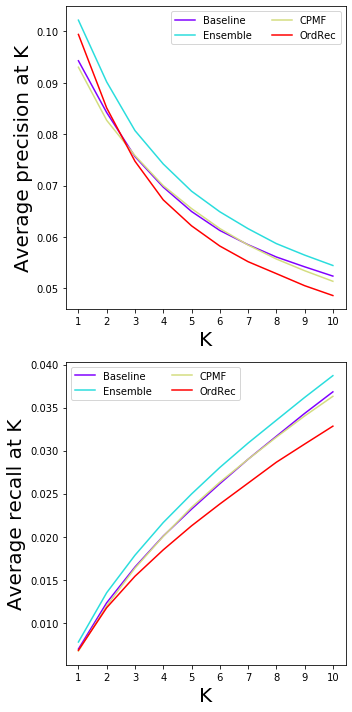

In [37]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 4)))
f, ax = plt.subplots(nrows=2, figsize=(5, 10))
for key in keys:
    c = next(color)
    ax[0].plot(np.arange(1, 11), models[key].evaluation['Precision'].cpu().detach().numpy(), '-', color=c, label=key)
    ax[1].plot(np.arange(1, 11), models[key].evaluation['Recall'].cpu().detach().numpy(), '-', color=c, label=key)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('K', Fontsize=20)
ax[0].set_ylabel('Average precision at K', Fontsize=20)
ax[0].legend(ncol=2)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xticklabels(np.arange(1, 11))
ax[1].set_xlabel('K', Fontsize=20)
ax[1].set_ylabel('Average recall at K', Fontsize=20)
ax[1].legend(ncol=2)
f.tight_layout()
f.savefig('Empirical study/GB/precision_recall.pdf')

In [38]:
keys = list(models.keys())[1:]
out = DataFrame(np.zeros((3, 9)), index=['RPI', 'Pearson', 'Spearman'], columns=keys)
for key in keys:
    out[key] = (models[key].evaluation['RPI'].item(), 
                models[key].evaluation['Correlation'][0].item(), 
                models[key].evaluation['Correlation'][1].item())
out.T

,RPI,Pearson,Spearman
User support,0.060806,0.021630,0.018800
Item support,0.002364,0.036093,0.066493
Item variance,0.451395,0.119742,0.108309
Ensemble,0.312545,0.058659,0.011982
Resample,0.471018,0.088388,0.043763
FCV,0.720199,0.206619,0.184026
BCV,0.938012,0.292711,0.262238
CPMF,1.023234,0.331137,0.313036
OrdRec,0.256229,0.170470,0.334152


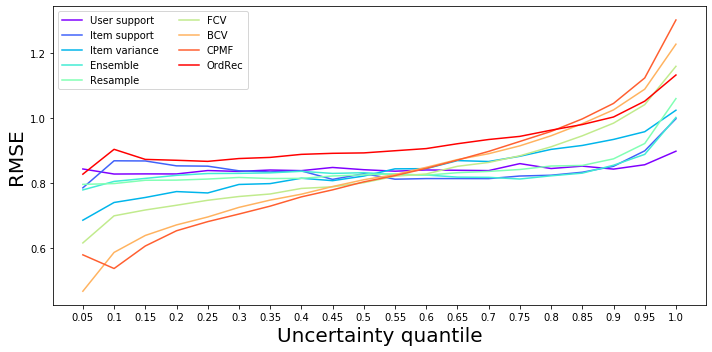

In [43]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    c = next(color)
    ax.plot(np.arange(1, 21), models[key].evaluation['Quantile RMSE'], '-', color=c, label=key)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels(np.round(np.linspace(start=0.05, stop=1, num=20, endpoint=True), 2))
ax.set_xlabel('Uncertainty quantile', Fontsize=20)
ax.set_ylabel('RMSE', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()
f.savefig('Empirical study/GB/RMSE_uncertainty.pdf')

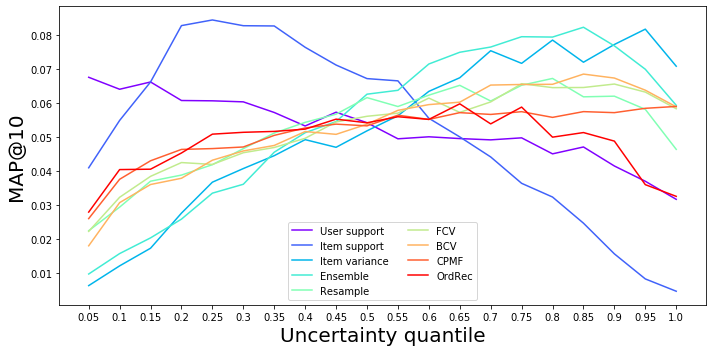

In [44]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    c = next(color)
    ax.plot(np.arange(1, 21), models[key].evaluation['Quantile MAP'], '-', color=c, label=key)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels(np.round(np.linspace(start=0.05, stop=1, num=20, endpoint=True), 2))
ax.set_xlabel('Uncertainty quantile', Fontsize=20)
ax.set_ylabel('MAP@10', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()
f.savefig('Empirical study/GB/MAP_uncertainty.pdf')

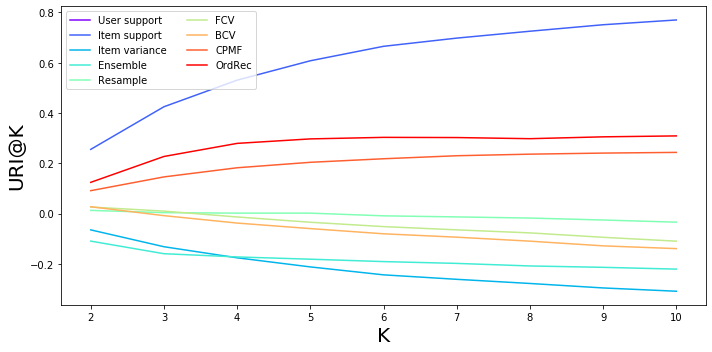

In [45]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    c = next(color)
    ax.plot(np.arange(2, 11), models[key].evaluation['RRI'], '-', color=c, label=key)
ax.set_xlabel('K', Fontsize=20)
ax.set_ylabel('URI@K', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()
f.savefig('Empirical study/GB/RRI.pdf')

In [42]:
results = DataFrame((np.zeros((2, 9))), index=['Likelihood', 'AUC'], columns=keys)
for key in keys:
    results[key] = models[key].evaluation['Classification']
results.T

,Likelihood,AUC
User support,-0.532883,0.511238
Item support,-0.532518,0.534083
Item variance,-0.528288,0.570672
Ensemble,-0.527512,0.511715
Resample,-0.531117,0.528983
FCV,-0.519850,0.610499
BCV,-0.502803,0.665844
CPMF,-0.500259,0.686368
OrdRec,-0.511162,0.596417
